In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: archive/
   creating: archive/Celebrity Faces Dataset/
   creating: archive/Celebrity Faces Dataset/Angelina Jolie/
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/001_fe3347c0.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/002_8f8da10e.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/003_57612506.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/004_f61e7d0c.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/005_582c121a.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/006_9135205d.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/007_cabbfcbb.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/008_d1f87068.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/009_fb3e6174.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/010_f99d79e3.jpg  
  inflating: archive/Celebrity Faces Dataset/Angelina Jolie/01

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
batch_size = 32
img_size = 224
num_epochs = 30
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset_dir = 'archive/Celebrity Faces Dataset/'
train_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.dataset.classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy

def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    epoch_loss = running_loss / len(val_loader.dataset)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')



Epoch 1/30, Train Loss: 1.8125, Train Acc: 40.96%, Val Loss: 1.3707, Val Acc: 55.00%
Epoch 2/30, Train Loss: 0.8603, Train Acc: 71.54%, Val Loss: 0.8248, Val Acc: 72.65%
Epoch 3/30, Train Loss: 0.5325, Train Acc: 81.91%, Val Loss: 0.8153, Val Acc: 75.29%
Epoch 4/30, Train Loss: 0.3331, Train Acc: 88.75%, Val Loss: 0.7711, Val Acc: 75.00%
Epoch 5/30, Train Loss: 0.3132, Train Acc: 89.12%, Val Loss: 0.6717, Val Acc: 78.82%
Epoch 6/30, Train Loss: 0.1277, Train Acc: 96.03%, Val Loss: 0.5125, Val Acc: 85.29%
Epoch 7/30, Train Loss: 0.0627, Train Acc: 98.38%, Val Loss: 0.4750, Val Acc: 86.47%
Epoch 8/30, Train Loss: 0.0400, Train Acc: 98.97%, Val Loss: 0.5199, Val Acc: 85.29%
Epoch 9/30, Train Loss: 0.0599, Train Acc: 98.31%, Val Loss: 0.4913, Val Acc: 85.88%
Epoch 10/30, Train Loss: 0.0576, Train Acc: 98.09%, Val Loss: 0.6156, Val Acc: 81.76%
Epoch 11/30, Train Loss: 0.0406, Train Acc: 98.75%, Val Loss: 0.4640, Val Acc: 87.65%
Epoch 12/30, Train Loss: 0.0295, Train Acc: 99.26%, Val Loss: 0

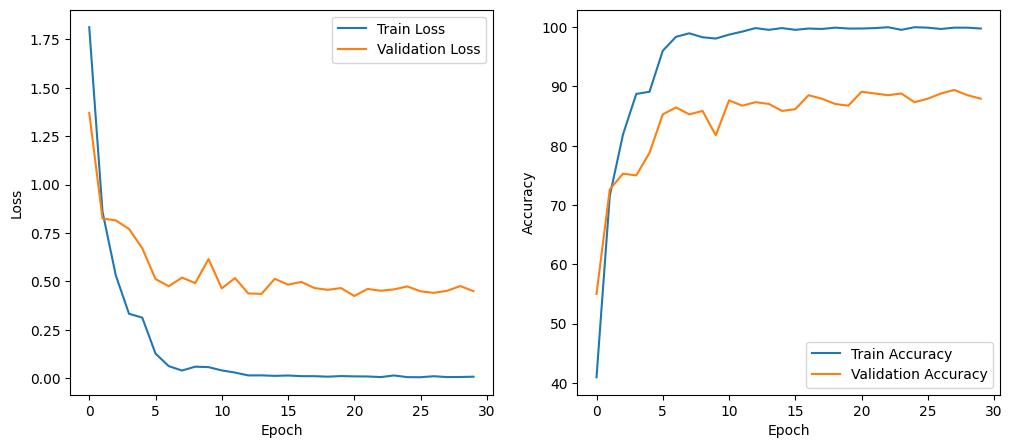

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def predict_image(image_path, model, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        predicted_class = train_dataset.dataset.classes[predicted.item()]
    print(f"Predicted class: {predicted_class} with {confidence[predicted].item():.2f}% confidence.")
predict_image('images.jpg', model, device)

Predicted class: Scarlett Johansson with 99.95% confidence.
